# CRIC Autoplier Survival Analysis 

In [3]:
import os
import autoplier.model as ap
import autoplier.plot as plot

import pandas as pd
import numpy as np

#from functools import reduce

from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sksurv.metrics import concordance_index_censored

import matplotlib.pyplot as plt


#import csv
#import h5py
#import json
#import mygene
#from onto_lib import general_ontology_tools as got
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import precision_score, recall_score, average_precision_score
#from sklearn.decomposition import PCA
#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import MultiLabelBinarizer
#

# Setup

In [196]:
# seed
seed = 3306059

# data path
datadir = os.path.join('data')

#results path
outdir = os.path.join('results')

#APRT quantile cutoff
APRT_quant = 1/3


# Download Data

In [5]:
# - - - - - - Download Data  - - - - - -
#get membership data
#membdf=pd.read_csv(os.path.join(datadir, 'membership.csv'), sep=',')
membdf=pd.read_csv(os.path.join(datadir, 'ion2pathway.csv'), sep=',')
#print(membdf.columns)

#get omics data
omdf=pd.read_csv(os.path.join(datadir, 'untargeted_annotatedions.csv'), sep=',')
#print(omdf.columns)

#get omics annotations
anndf=pd.read_csv(os.path.join(datadir, 'CRIC_annotation_1mD_neg.csv'), sep=',')

#get clinical data
#clindf=pd.read_csv(os.path.join(datadir, 'partitioning.csv'),index_col='record_id', sep=',')
clindf=pd.read_csv(os.path.join(datadir, 'preprocessing_results.csv'), sep=',')
#print(clindf.columns)


In [6]:
#get omics annotations
#print(anndf.columns)
#print(membdf.columns[0:10])
#print(omdf.columns[0:10])
#print(clindf.columns)

# Sanity Check Data

In [7]:
clindf.head()

,patientid,mu_egfr_rate,sigma_egfr_rate,acearb_v3y0,african_ancestry_v3y0,age_integer_v3y0,albuminuria_v3y0,apol1_risk_alleles_v3y0,caucasian_ancestry_v3y0,chinese_japanese_ancestry_v3y0,...,time_mi_p_cnsr_v3y0,time_pad_v3y0,time_pad_cnsr_v3y0,ualbumin24h_v3y0,ucreatinine24h_v3y0,uprotein24h_v3y0,urine_albumin_v3y0,urine_creatinine_v3y0,urine_protein_mg_dl_v3y0,waist_v3y0
0,1010001,-0.068201,0.188699,1,6.6,70,1,0,88.4,5.0,...,10.906849,10.906849,10.906849,0.007304,1.041892,0.029217,2.5,35.66,1,100.5
1,1010007,-0.105450,0.199372,1,82.2,69,3,1,16.6,1.3,...,0.383562,4.875470,4.875470,0.414370,1.117583,0.573639,122.8,33.12,17,83.0
2,1010008,-0.012396,0.218453,1,80.7,68,2,1,18.1,1.1,...,5.605479,5.605479,5.605479,0.043890,2.045274,0.079800,16.5,76.89,3,108.0
3,1010013,-0.054251,0.244502,1,84.3,61,3,2,13.7,2.0,...,7.202740,10.753425,7.202740,0.381342,1.513498,0.593529,205.6,81.60,32,98.0
4,1010015,-0.290542,0.361062,1,10.4,49,4,0,88.5,1.1,...,4.949203,10.778082,4.949203,7.817500,2.268665,8.374000,2950.0,85.61,316,109.5


 # Formatting

In [8]:
#make patientid an integer in clindf an make it the index
clindf['patientid'] = clindf['patientid'].astype(int)
clindf = clindf.set_index('patientid')

#remove the 'V' prefix in the omic column names
oldcols = omdf.columns[3:]
newcols = omdf.columns[3:].str[1:]
coldict = {oldcols[i]: newcols[i] for i in range(len(oldcols))}
omdf.rename(columns=coldict, inplace=True)

#name ion column in membership data
membdf.rename(columns={'Unnamed: 0': 'ion'}, inplace=True)

#convert the ion column to a string in membership data
membdf['ion'] = membdf['ion'].astype(str)

# Partition Data

In [9]:
#  - - - - - - Partition Data  - - - - - -
#partition observations by group
trainrecs = omdf.index[omdf["group"]<4].to_series()
validrecs = omdf.index[omdf["group"]==4].to_series()
allrecs = pd.concat([trainrecs,validrecs])

#get Xtrain and Xvalid
Xtrain = omdf.loc[trainrecs, : ].set_index('patientid')
Xvalid = omdf.loc[validrecs, : ].set_index('patientid')

#drop uncessary columns
Xtrain.drop(columns=["visit", "group"], inplace=True)
Xvalid.drop(columns=["visit", "group"], inplace=True)
#print(Xtrain.columns)
#print(Xvalid.columns)

In [10]:
# - - - - - -  QC  - - - - - -
#remove inf
Xtrain = Xtrain.replace( np.inf , np.nan )
Xvalid = Xvalid.replace( np.inf , np.nan )

#replace NA with half the minimum
Xtrain = Xtrain.replace(np.nan, np.min(Xtrain, axis=0)/2)
Xvalid = Xvalid.replace(np.nan, np.min(Xvalid, axis=0)/2)

#assert all values are complete and positive
assert(np.all(~Xtrain.isnull()))
assert(np.all(Xtrain>0))

In [11]:
# demonstrate partitions cannot be predicted
#(todo)

In [12]:
#print(omdf)

# Omics to pathway transformation

In [13]:
#assert all omics are in the membership data
missingomics =  Xtrain.columns[~Xtrain.columns.isin(membdf["ion"])]
if len(missingomics)>0:
    # WARNING: missing omics
    print("the following omics were not found in the membership data.")
    print(missingomics)
assert(len(missingomics)==0)

In [14]:
#get the standardized omics labels for the columns in X
bigomega = Xtrain.columns
#print(bigomega)

In [15]:
#order membership data by the omics order (columns of X)
Cmat = membdf.set_index("ion")
Cmat = Cmat.reindex(bigomega)
#print(Cmat)

In [16]:
#transpose membership matrix so pathways are in rows and omics are in columns
Cmat = Cmat.T

#get unique pathways
_, uidx, invidx = np.unique(Cmat, return_index=True, return_inverse=True, axis=0)
Cmat = Cmat.iloc[uidx]

#print(Cmat.head())
#print(Cmat.shape)
#get the known pathway and metbolite classes (Pi) order
bigpi = Cmat.columns

In [17]:
#--- dump formatted xtrain, xvalid, and cmat
Xtrain.to_csv(os.path.join(outdir, 'Xtrain.csv'))
Xvalid.to_csv(os.path.join(outdir, 'Xvalid.csv'))
Cmat.to_csv(os.path.join(outdir, 'Cmat.csv'))
clindf.to_csv(os.path.join(outdir, 'clinical.csv'), index=True)

# Autoplier
Autoplier is an unsupervised dimension reduction method that transforms the longitudinal metabolomics data into the pathway representation.

## Setup

In [18]:
#fixed hyperparameters
maxepoch = 2000
patience = 100
batch_size= None
valfrac = .3
learning_rate = .002
decay_rate= learning_rate/maxepoch
regval = 1E-7

In [19]:
# Autoplier callbacks
callbacks = [
        #early stopping - to mitigate overfitting
        EarlyStopping(patience=patience, monitor='val_loss'),
        #monitor umatrix sparsity
        ]

## Estimate number of latent variables

In [20]:
#  - - - - - - Init guess data compressibility  - - - - - -
# Full dof PCA for all data
pca = PCA(random_state = seed) #do not define number of PCs

#transform omics into pathway representation
Xtilde = np.dot(Xtrain, Cmat.T.to_numpy())

#fit pca on the training data
X_pca = pca.fit_transform(Xtilde)

# compute total variation explained
totvar = sum(pca.explained_variance_)
cum_var = np.cumsum(pca.explained_variance_)/totvar

#show variation explained (diagnostic only)
#nPC = 50
#print(cum_var[0:nPC])

#choose nLV = whichever is less: 2 times the number of PCs that explain 99% of variation, or 90% of pathways
nLV = np.min([len(np.where(cum_var<=.99)[0])*2, len(Cmat.index)*.90]).astype(int)
print("Number of Latent Variables is "+ str(nLV))

Number of Latent Variables is 42


## Estimate regularization constant

In [21]:
# --- init guess target sparsity based on size LV matrix (bigPI x nLV) ---
# say the LVs are non trivial with 10 major Pathway components in each 
# 1- (nLV * 10) / (nLV * npathways)
target_sparsity = 1 - (10/len(bigpi))
#print(len(bigpi))
print("targetsparsity is " + str(target_sparsity))

targetsparsity is 0.9964349376114082


In [22]:
#Optimize regularizaton for given target sparsity
def optimize_l1(target_sparsity, delta, start_l1, X, pathways, n_components):
 
    #initialize values
    ap.set_seed_(seed)
    nrep = 5
    sparsity = np.zeros(nrep)
    mu = np.mean(sparsity)
    #sparsity = 0
    tuning_l1 = start_l1
    step = 10
    closest = 1
    closest_l1 = tuning_l1
    #while abs(sparsity - target_sparsity) > delta:
    while abs(mu - target_sparsity) > delta:

        #reinit sparsity buffer
        sparisity = None
        
        #train model replicates
        for imodel in range(nrep):

            #create model
            mod = ap.autoPLIER(n_components, regval=tuning_l1, learning_rate=learning_rate)

            #set normalizer
            ap.scaler = Normalizer(norm='l1', copy=True)

            #train model
            mod.fit(X, pathways, callbacks, batch_size=batch_size,
                    maxepoch=maxepoch, verbose=0, valfrac=valfrac)

            #compute sparsity :number of elements greater than epsilon(1E-4)
            sparsity[imodel] = ap.sparsity_epsilon(mod.components_decomposition_, 10 ** -4)

        print(sparsity)
        #print mean, std and CV of sparsity
        mu = np.mean(sparsity)
        sigma = np.std(sparsity)
        print(mu, sigma, sigma/mu)
            
        #compute distance to target sparsity
        #diff = sparsity - target_sparsity
        diff = mu - target_sparsity
        
        #update closest sparsity
        if abs(diff) < closest and diff < 0:
            closest = abs(diff)
            closest_l1 = tuning_l1
            #check if diff is still to big else main loop should end
            if abs(diff) > delta:
                tuning_l1 = tuning_l1 * step

        else:

            if diff > 0:
                step = step / 2
                tuning_l1 = closest_l1 * step
            else:
                tuning_l1 = closest_l1 / step
                step = step / 2
                tuning_l1 = tuning_l1 * step
                
        #print(sparsity, diff, closest_l1)
        print(diff, closest_l1)
        
    return closest_l1

In [23]:
# set regularization value to aim for target sparsity
#regval = optimize_l1(target_sparsity=target_sparsity, delta=.005, start_l1=1E-5, X=Xtrain, pathways=Cmat, n_components=nLV)

In [24]:

print("L1 regularization value is " + str(regval))

L1 regularization value is 1e-07


## Train autoplier

In [25]:
# unsupervised training scheme
def train_autoplier(X, pathways, n_LVs, regval):
    #set seed
    ap.set_seed_(seed)

    #create model
    model = ap.autoPLIER(n_LVs, regval = regval, learning_rate= learning_rate)
    #model = ap.autoPLIER(n_LVs, regval = 0, learning_rate= learning_rate)
    
    #set normalizer
    ap.scaler = Normalizer(norm='l1', copy=True)
    
    #fit model
    model.fit(X, pathways, callbacks, batch_size=batch_size, maxepoch=maxepoch, verbose=0, valfrac=valfrac)
    
    # compute latent variables
    Z = model.transform(X, pathways)
    
    # diagnostic - print sparsity
    print("Trained Model Sparsity is " +str(ap.sparsity_epsilon(model.components_decomposition_, 1.0E-4)))
    
    #return latent variables and trained model
    return Z, model

In [26]:
Z, model = train_autoplier(Xtrain, Cmat, nLV, regval)
#print(Z)

2022-03-25 16:35:55.100740: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Trained Model Sparsity is 0.9738955823293173


# Association of Latent variables with eGFR decline
We define a logistic regression classifier with optional adjustment for clinical variables and return the strongest predictive pathways for the positive and negative cases.

In [65]:
# define classifier
def classify(mod, Xtrain, Cmat, clin, clinadj=True, benchmark=False):
    
    #outcome = 'mu_egfr_rate'
    
    #select patients by record_id in the X data
    #y = clin[clin.index.isin(Xtrain.index)]

    ##drop pats with missing outcome
    #y = y.loc[~y['mu_egfr_rate'].isna()]
    
    #select Xtrain patients in the clinical variables
    X = Xtrain[Xtrain.index.isin(clin.index)]

    #drop duplicate patientids
    X = X[~X.index.duplicated(keep='first')]
 
    #get clinical variables for every patient in X
    y = clin.loc[X.index]

    #confirm equal number of samples
    assert(len(X.index)==len(y.index))
    
    #encode categorical outcome for rapid progressor based on eGFR rate
    le = LabelEncoder()
    le.fit([True, False])
    yt = le.transform(y['mu_egfr_rate'] > y['mu_egfr_rate'].mean())
    #yt = le.transform(y['mu_egfr_rate'] > y['mu_egfr_rate'].quantile(2/3))

    #drop egfr rate
    y.drop(columns=['mu_egfr_rate'], inplace=True)
 
    #encode categorical sex clinical variable
    le = LabelEncoder()
    le.fit(y['sex_v3y0'].unique())
    y['sex_v3y0'] = le.transform(y['sex_v3y0'])

    #encode categorical race clinical variable
    le = LabelEncoder()
    le.fit(y['race_ethnicity_cat2_v3y0'].unique())
    y['race_ethnicity_cat2_v3y0'] = le.transform(y['race_ethnicity_cat2_v3y0'])
      
    #transform Xtrain data into latent representation
    Z = mod.transform(X, Cmat)
    #get number of LVs
    nLV = Z.shape[1]
    
    #log and Zscore latent variables
    Z = np.log2(Z+1)
    Z = np.subtract(Z, np.mean(Z, axis=0))
    Z = np.divide(Z, np.std(Z, axis=0))

    #add clinical variables
    if clinadj:
        Z = Z.merge(y, on='patientid')
        
    #train clinical only model
    if benchmark:
        Z = y
    
    #gurantee column names are all strings
    Z.columns = Z.columns.astype(str)
    
    #Latent variable PCA represenation
    pca = PCA(n_components=2, random_state = seed)
    Z_pca = pca.fit_transform(Z)
    
    #visualize case/ctrl patients projected on first 2 prinicpal components
    fig = plt.figure()
    ax = fig.add_subplot()
    scatter = ax.scatter(Z_pca[:,0], Z_pca[:,1], c = yt)
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="fast progressors")
    ax.add_artist(legend1)

    ax.legend()
    plt.show()
    
    PARAMETERS = {
        'C': [
        0.001,
        0.002,
        0.005,
        0.01,
        0.02,
        0.05,
        0.1,
        0.2,
        0.5,
        1.0,
        2.0,
        5.0,
        10.0,
        20.0,
        50.0,    
        100.0,
        200.0,
        500.0,    
        1000.0,
        ]
    }
    MAX_ITER = 200000

    lr_model = LogisticRegression(penalty='l1', 
                                  solver='liblinear',
                                  #class_weight='balanced',
                                  random_state=seed)

    #clf = GridSearchCV(lr_model, PARAMETERS, scoring='f1')
    clf = GridSearchCV(lr_model, PARAMETERS, scoring='roc_auc')
    #clf = GridSearchCV(lr_model, PARAMETERS, scoring='neg_log_loss')
    clf.fit(Z, yt)

    best_params = max(
        zip(
            clf.cv_results_['param_C'], 
            clf.cv_results_['mean_test_score']
        ),
        key=lambda x: x[1]
    )
    best_C = best_params[0]
    #print('Mean test scores:')
    #print(clf.cv_results_['mean_test_score'])
    #print("Best C chosen: ", best_C)
    
    lr_model = LogisticRegression(penalty='l1', 
                                  solver='liblinear', 
                                  #class_weight='balanced',
                                  random_state=seed,
                                  C=best_C)
    #train model
    lr_model.fit(Z, yt)

    if not benchmark:
    
        #get coefficients
        coeffs = lr_model.coef_
        coeffs = coeffs.squeeze()
        #print(coeffs)

        #get only LV coeffs
        coeffs = coeffs[:nLV]

        #get the largest and smallest LVs 
        largest = coeffs.argsort()[-5:]
        smallest = coeffs.argsort()[:5]

        largest_vals = [coeffs[x] for x in largest]
        smallest_vals = [coeffs[x] for x in smallest]

        #limit to non-zero coeffs
        nlarge = len([i for i in largest_vals if i > 0])  
        nsmall = len([i for i in smallest_vals if i < 0])  

        #print any large LVs
        if nlarge>0:
            largest = largest[0:nlarge]
            largest_vals = largest_vals[0:nlarge]
            print("LVs associated with classification of rapid progressors :" )
            print(largest)
            print(largest_vals)
            for lv in largest:
                plot.plot_top_pathways([lv], 5, (10, nlarge), mod)
                plt.title(f'LV {lv}')
                plt.show()
        else:
            print("No LVs are associated with classification of rapid progressors!")

        #print any small LVs
        if nsmall>0:
            smallest = smallest[0:nsmall]
            smallest_vals = smallest_vals[0:nsmall]
            print("LVs associated with classification of slow progressors :" )
            print(smallest)
            print(smallest_vals)
            for lv in smallest:
                plot.plot_top_pathways([lv], 5, (10, nsmall), mod)
                plt.title(f'LV {lv}')
        else:
            print("No LVs are associated with classification of slow progressors!")

    return lr_model, Z, yt

# Full cohort analysis

In [87]:
#Select samples

#select normo + micro albuminuria patients
#clinred = clindf.loc[clindf['albuminuria_v3y0']<=2, covariates]

#select normo albuminuria patients
#clinred = clindf.loc[clindf['albuminuria_v3y0']==1, covariates]

#select all albuminuria patients
clinred = clindf.loc[clindf['albuminuria_v3y0']>0, ]

In [88]:
#Select variables

#covariates = ['mu_egfr_rate', 'sigma_egfr_rate', 'age_integer_v3y0', 'sex_v3y0', 'race_ethnicity_cat2_v3y0',
#              'map_v3y0','hemoglobin_a1c_v3y0','waist_v3y0',
#              'urine_albumin_v3y0', 'egfr_cric_v3y0']#, 'albuminuria_v3y0']
covariates = ['mu_egfr_rate', 'age_integer_v3y0', 'sex_v3y0', 'race_ethnicity_cat2_v3y0',
              'map_v3y0','hemoglobin_a1c_v3y0','waist_v3y0',
              'log2acr', 'egfr_cric_v3y0']#, 'albuminuria_v3y0']
#print(clindf[covariates])

#log transform urine_albumin to urine creatinine ratio
#clinred['urine_albumin_v3y0'] = np.log2(clinred['urine_albumin_v3y0']+1)
clinred['log2acr'] = np.log2(clinred['urine_albumin_v3y0']+1) - np.log2(clinred['urine_creatinine_v3y0']+1)

clinred_full = clinred[covariates]
#display(clinred)

# benchmark model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


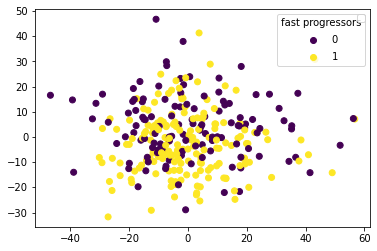

In [89]:
fullcohort_model_clin, Z_fullcohort_clin, y_fullcohort_clin = classify(model, Xtrain, Cmat, clinred_full, benchmark=True)




## Top latent variables for predicting rapid eGFR decline unadjusted

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


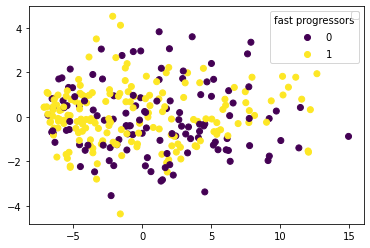

No LVs are associated with classification of rapid progressors!
LVs associated with classification of slow progressors :
[35 29]
[-0.137582656333249, -0.012507659564070114]


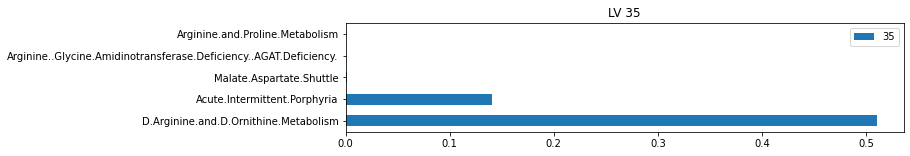

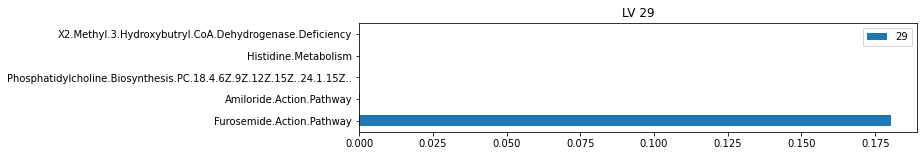

In [90]:
fullcohort_model_unadj, Z_fullcohort_unadj, y_fullcohort_unadj = classify(model, Xtrain, Cmat, clinred_full, clinadj=False)

## Top latent variables for predicting rapid eGFR decline with adjustment for clinical variables

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


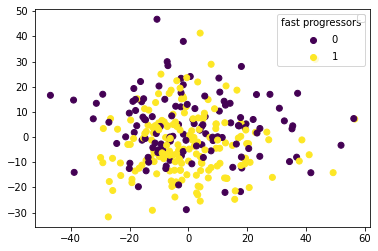

No LVs are associated with classification of rapid progressors!
No LVs are associated with classification of slow progressors!


In [91]:
fullcohort_model, Z_fullcohort, y_fullcohort = classify(model, Xtrain, Cmat, clinred_full, clinadj=True)

## Comparison of ROC curves between adjusted and unadjusted models 

In [92]:
def comapre_ROC(model, X, y, model_adj, X_adj, y_adj, model_clin, X_clin, y_clin):
    # ROC curve
    from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

    # prepare plots
    fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

    #adjsuted model
    RocCurveDisplay.from_estimator(model_adj, X_adj, y_adj, ax=ax_roc, name='adjusted model')
    DetCurveDisplay.from_estimator(model_adj, X_adj, y_adj, ax=ax_det, name='adjusted model')


    #unadjusted model
    RocCurveDisplay.from_estimator(model, X, y, ax=ax_roc, name='unadjusted model')
    DetCurveDisplay.from_estimator(model, X, y, ax=ax_det, name='unadjusted model')

    #benchmark model
    RocCurveDisplay.from_estimator(model_clin, X_clin, y_clin, ax=ax_roc, name='benchmark model')
    DetCurveDisplay.from_estimator(model_clin, X_clin, y_clin, ax=ax_det, name='benchmark model')

    ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
    ax_det.set_title("Detection Error Tradeoff (DET) curves")

    ax_roc.grid(linestyle="--")
    ax_det.grid(linestyle="--")

    plt.legend()
    plt.show()

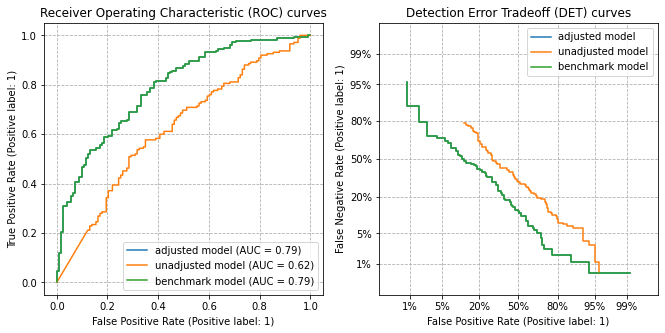

In [93]:
comapre_ROC(fullcohort_model_unadj, Z_fullcohort_unadj, y_fullcohort_unadj,
            fullcohort_model, Z_fullcohort, y_fullcohort,
            fullcohort_model_clin, Z_fullcohort_clin, y_fullcohort_clin)

# Normoalbuminuria group analysis

In [94]:
#Select samples

#select normo + micro albuminuria patients
#clinred = clindf.loc[clindf['albuminuria_v3y0']<=2]

#select normo albuminuria patients
clinred = clindf.loc[clindf['albuminuria_v3y0']==1]

In [95]:
#Select variables

#covariates = ['mu_egfr_rate', 'sigma_egfr_rate', 'age_integer_v3y0', 'sex_v3y0', 'race_ethnicity_cat2_v3y0',
#              'map_v3y0','hemoglobin_a1c_v3y0','waist_v3y0',
#              'urine_albumin_v3y0', 'egfr_cric_v3y0']#, 'albuminuria_v3y0']
covariates = ['mu_egfr_rate', 'age_integer_v3y0', 'sex_v3y0', 'race_ethnicity_cat2_v3y0',
              'map_v3y0','hemoglobin_a1c_v3y0','waist_v3y0',
              'log2acr', 'egfr_cric_v3y0']#, 'albuminuria_v3y0']
#print(clindf[covariates])

#log transform urine_albumin to urine creatinine ratio
clinred['log2acr'] = np.log2(clinred['urine_albumin_v3y0']+1) - np.log2(clinred['urine_creatinine_v3y0']+1)
clinred_normo = clinred[covariates]
#display(clinred)

/var/folders/v3/d9c1pzwx0ld7sf9x7_4wzy4c0000gq/T/ipykernel_46964/186333728.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinred['log2acr'] = np.log2(clinred['urine_albumin_v3y0']+1) - np.log2(clinred['urine_creatinine_v3y0']+1)


# benchmark model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


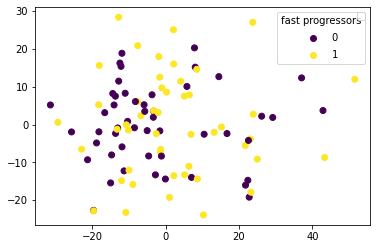

/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/m

In [96]:
normo_model_clin, Z_normo_clin, y_normo_clin = classify(model, Xtrain, Cmat, clinred_normo, benchmark=True)




## Top latent variables for predicting rapid eGFR decline unadjusted

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


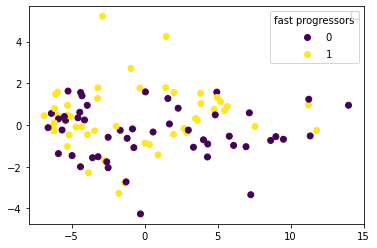

/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/m

LVs associated with classification of rapid progressors :
[21 10  1 17 16]
[3.0537751998562066, 3.109404178273325, 3.699788940346257, 5.252856810332323, 6.059349369849345]


/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


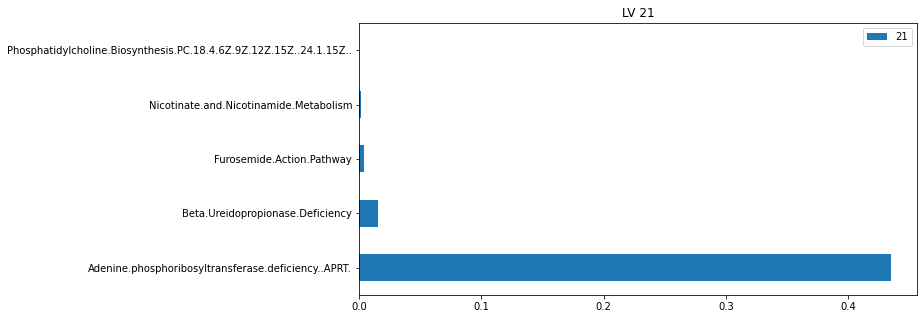

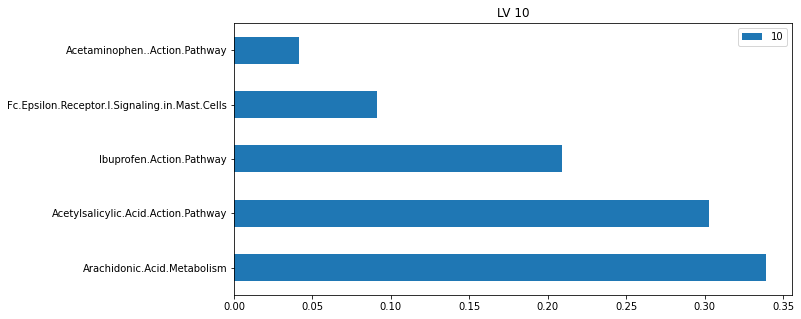

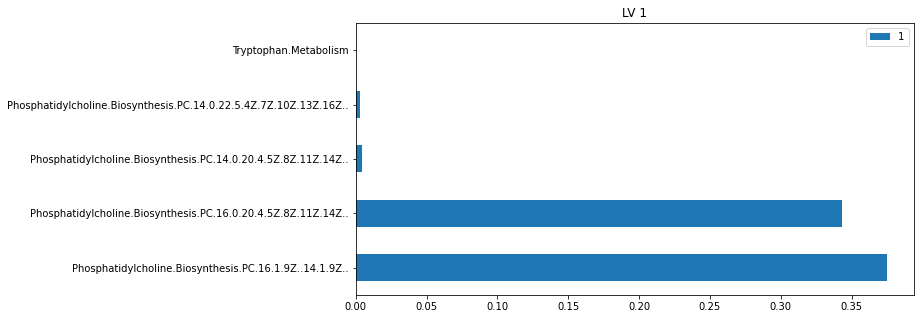

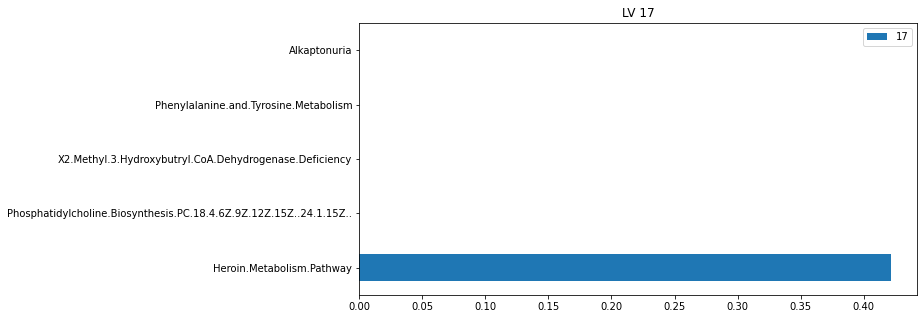

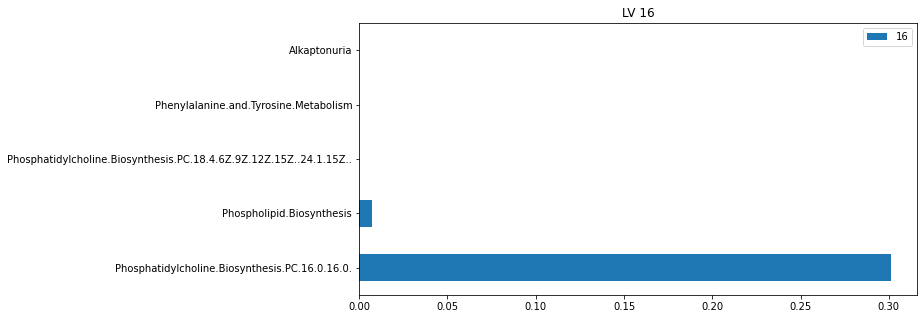

LVs associated with classification of slow progressors :
[13  7  6 38 26]
[-10.02403651842593, -8.920814052860338, -2.946321603800637, -1.976546825484138, -1.9487218504148072]


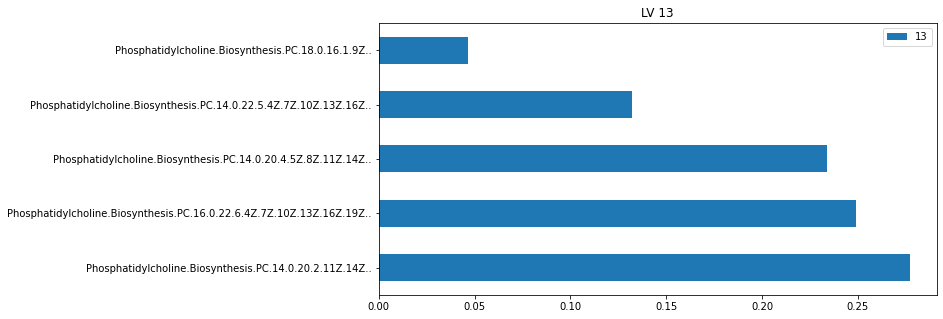

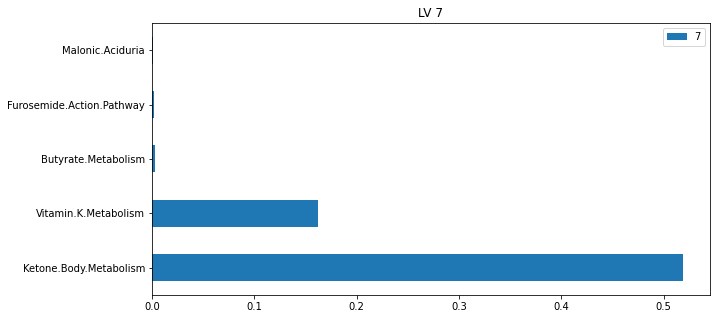

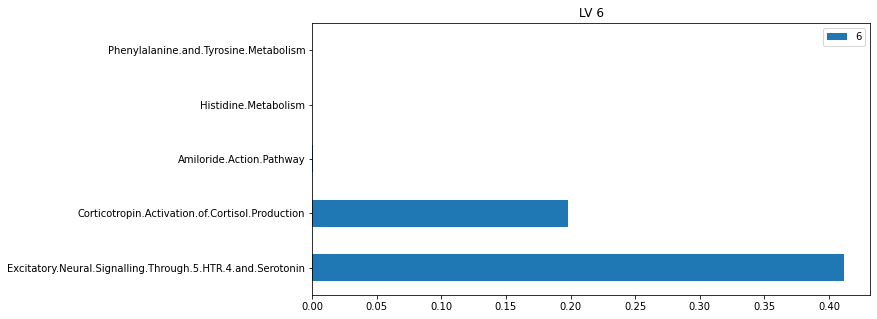

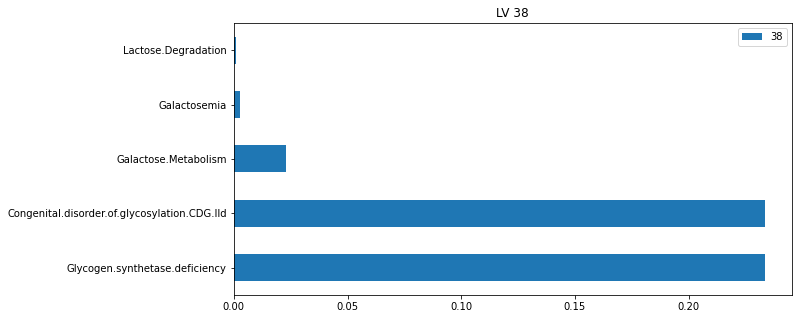

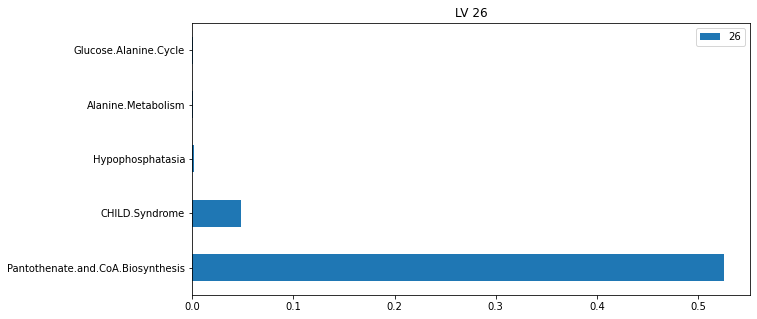

In [97]:
normo_model_unadj, Z_normo_unadj, y_normo_unadj = classify(model, Xtrain, Cmat, clinred_normo, clinadj=False)

## Top latent variables for predicting rapid eGFR decline with adjustment for clinical variables

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


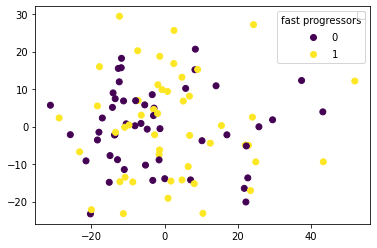

/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LVs associated with classification of rapid progressors :
[16  1 21 17 10]
[1.8361431576853742, 2.484006315721655, 3.024888129904777, 4.764605639274834, 6.965314894234217]


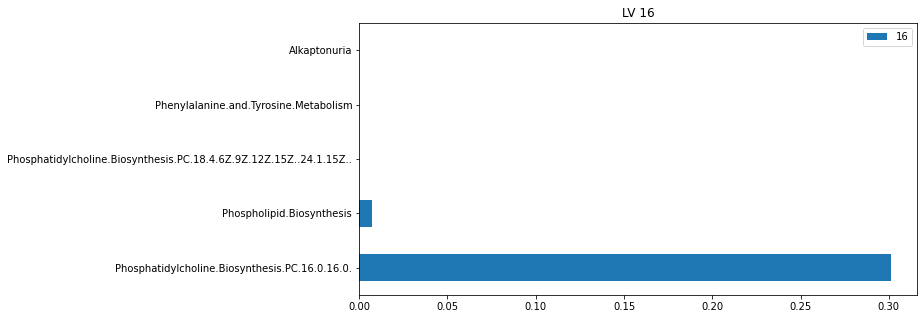

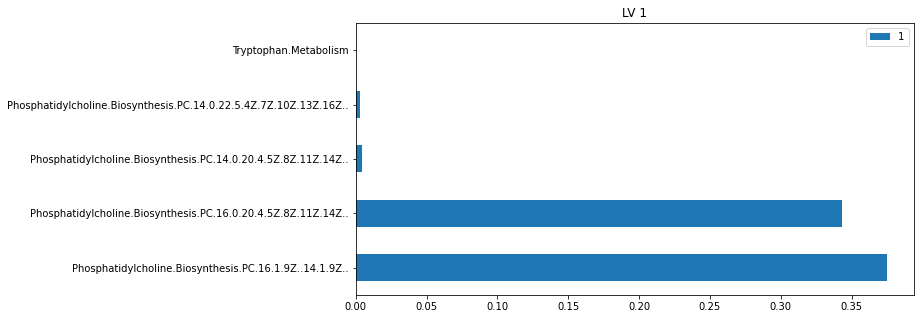

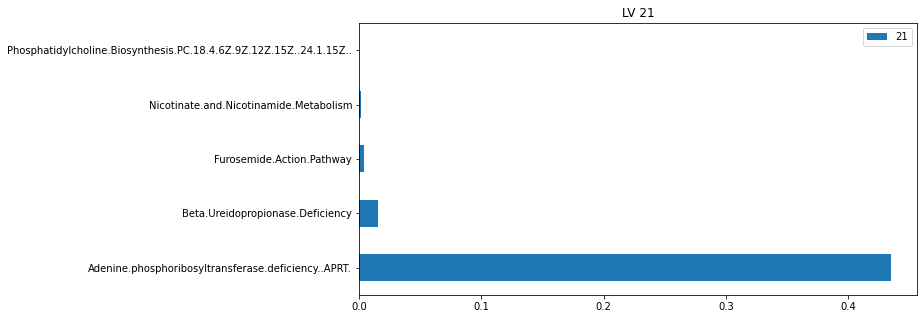

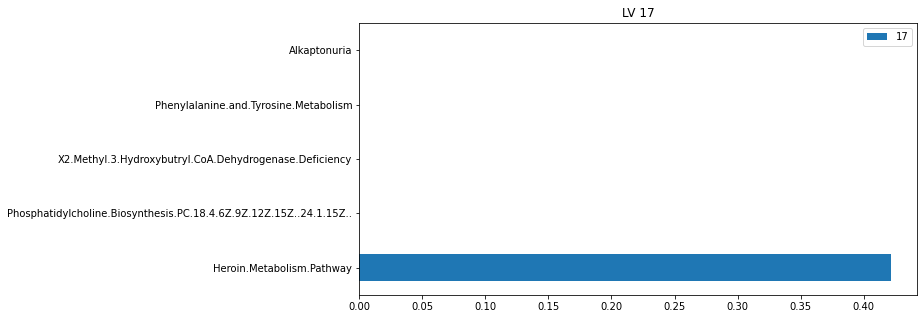

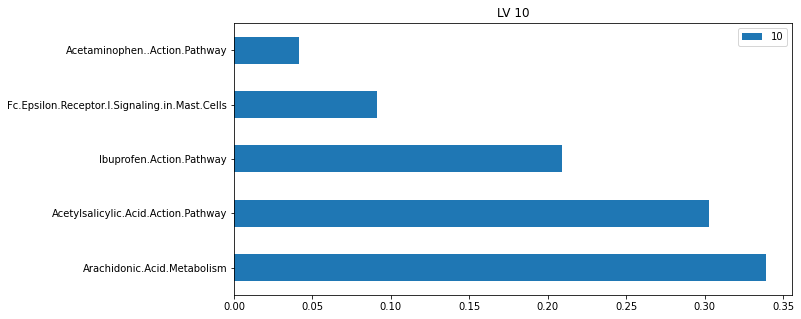

LVs associated with classification of slow progressors :
[ 7 13 36  6  9]
[-7.120235481986992, -6.575999082344967, -2.9386257591010003, -2.487229816510792, -1.9963785549379622]


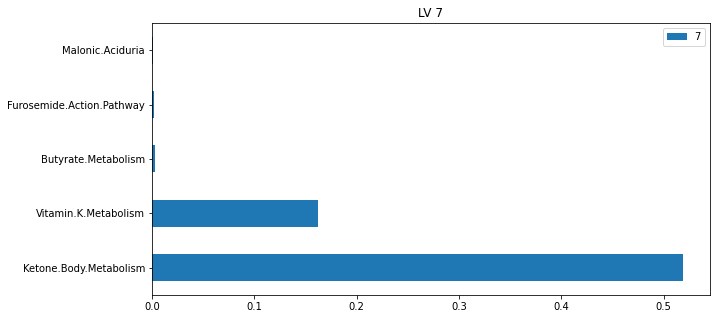

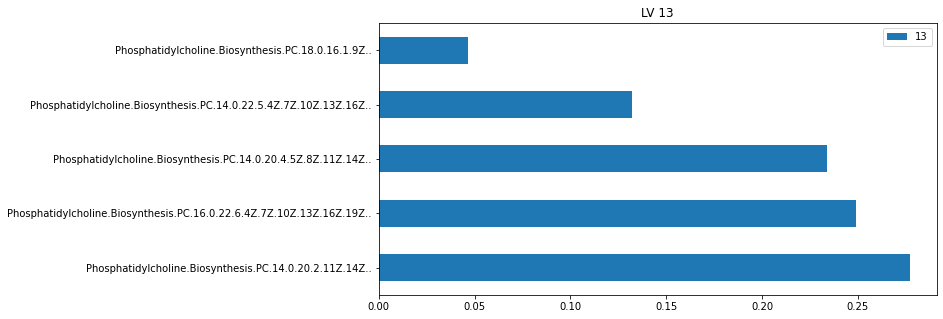

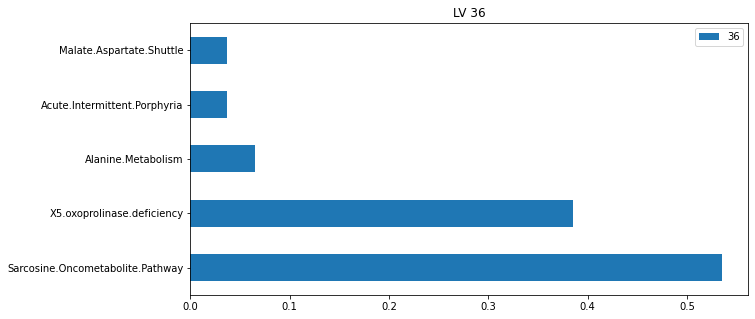

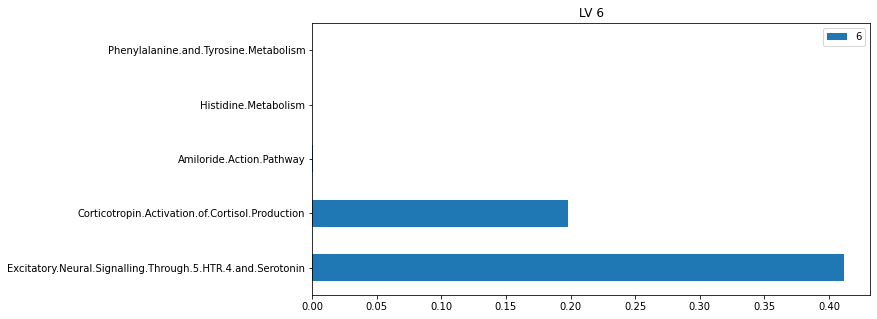

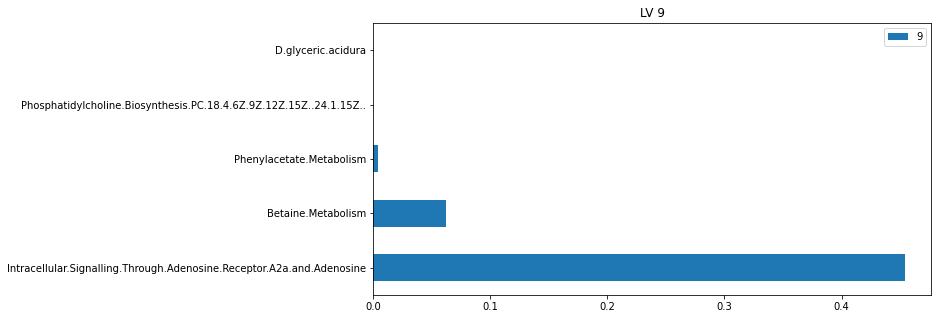

In [98]:
 normo_model, Z_normo, y_normo = classify(model, Xtrain, Cmat, clinred_normo, clinadj=True)

## Comparison of ROC curves between adjusted and unadjusted models 

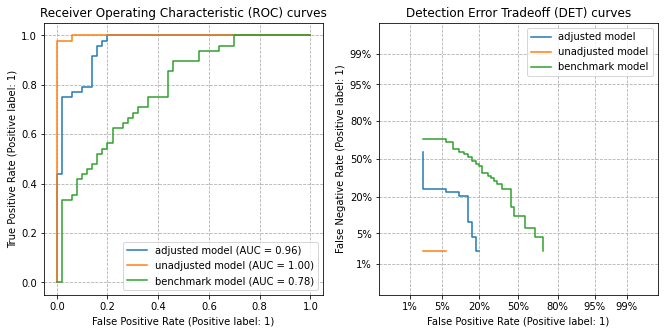

In [99]:
comapre_ROC(normo_model, Z_normo, y_normo,
            normo_model_unadj, Z_normo_unadj, y_normo_unadj,
            normo_model_clin, Z_normo_clin, y_normo_clin)

# Normo and Micro albuminuria group analysis

In [100]:
#Select samples

#select normo + micro albuminuria patients
clinred = clindf.loc[clindf['albuminuria_v3y0']<=2]

In [101]:
#Select variables

#covariates = ['mu_egfr_rate', 'sigma_egfr_rate', 'age_integer_v3y0', 'sex_v3y0', 'race_ethnicity_cat2_v3y0',
#              'map_v3y0','hemoglobin_a1c_v3y0','waist_v3y0',
#              'urine_albumin_v3y0', 'egfr_cric_v3y0']#, 'albuminuria_v3y0']
covariates = ['mu_egfr_rate', 'age_integer_v3y0', 'sex_v3y0', 'race_ethnicity_cat2_v3y0',
              'map_v3y0','hemoglobin_a1c_v3y0','waist_v3y0',
              'log2acr', 'egfr_cric_v3y0']#, 'albuminuria_v3y0']
#print(clindf[covariates])

#log transform urine_albumin to urine creatinine ratio
clinred['log2acr'] = np.log2(clinred['urine_albumin_v3y0']+1) - np.log2(clinred['urine_creatinine_v3y0']+1)
clinred_normomicro = clinred[covariates]
#display(clinred)

/var/folders/v3/d9c1pzwx0ld7sf9x7_4wzy4c0000gq/T/ipykernel_46964/3313650863.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinred['log2acr'] = np.log2(clinred['urine_albumin_v3y0']+1) - np.log2(clinred['urine_creatinine_v3y0']+1)


# benchmark model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


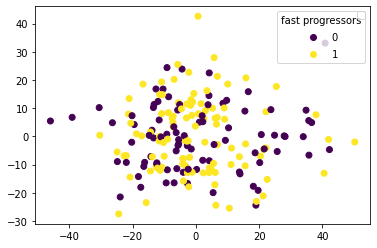

/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [102]:
normomicro_model_clin, Z_normomicro_clin, y_normomicro_clin = classify(model, Xtrain, Cmat, clinred_normomicro, benchmark=True)




## Top latent variables for predicting rapid eGFR decline unadjusted

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


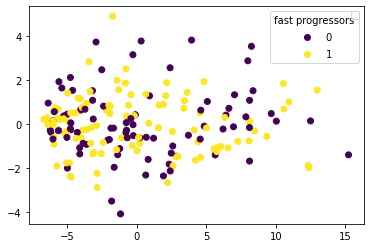

LVs associated with classification of rapid progressors :
[36 10 14 33 25]
[0.6226335744958597, 0.6999772755014558, 0.7012712229233433, 0.706992009116247, 0.9503552462303162]


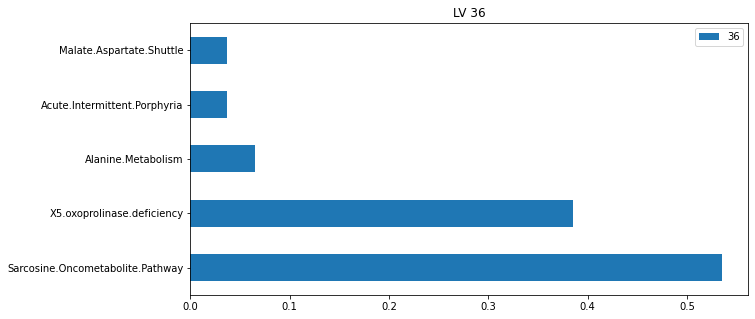

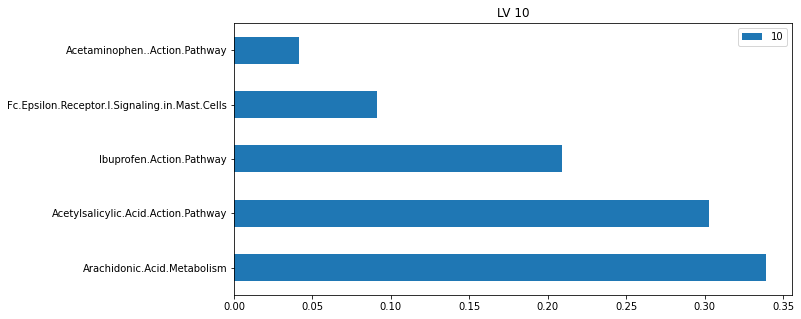

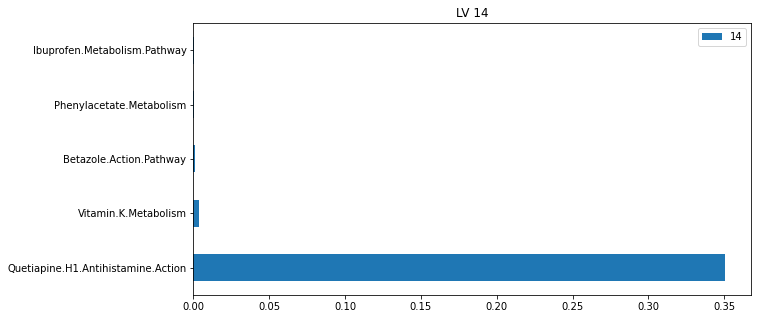

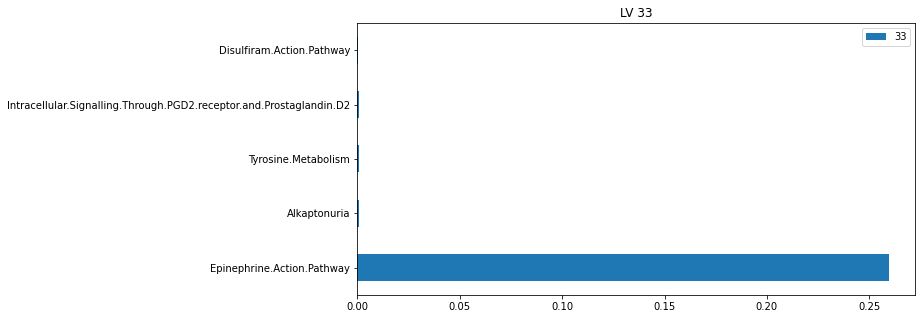

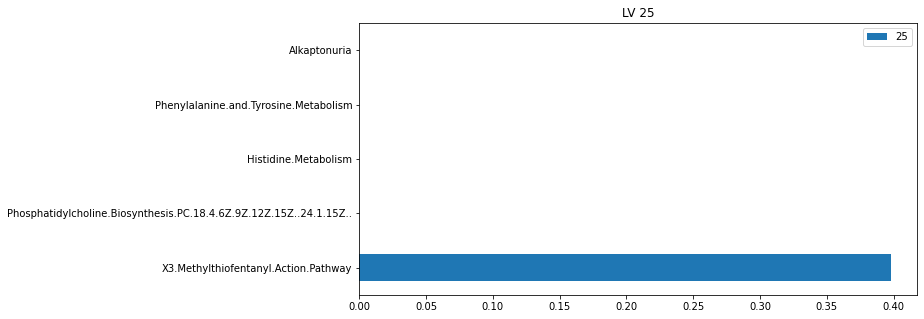

LVs associated with classification of slow progressors :
[35 26  9  7 11]
[-1.3787044803695498, -1.0229674090624234, -0.6048385126570882, -0.5847880145997788, -0.5287837649797477]


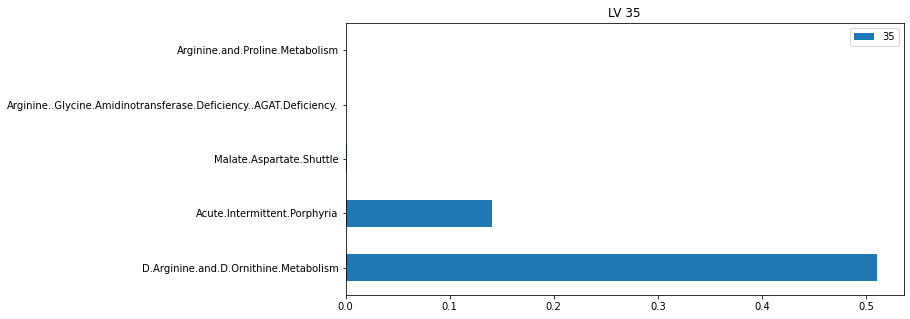

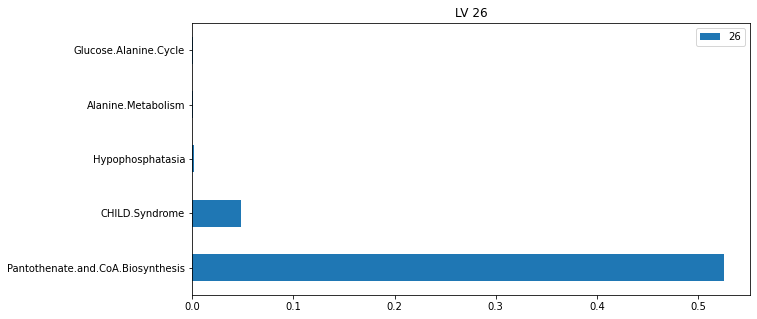

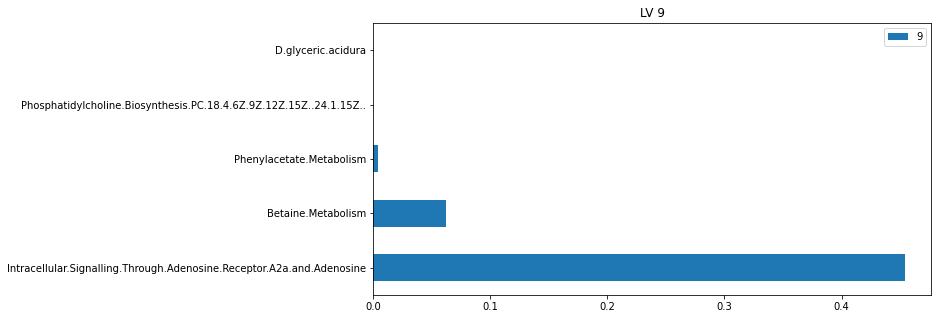

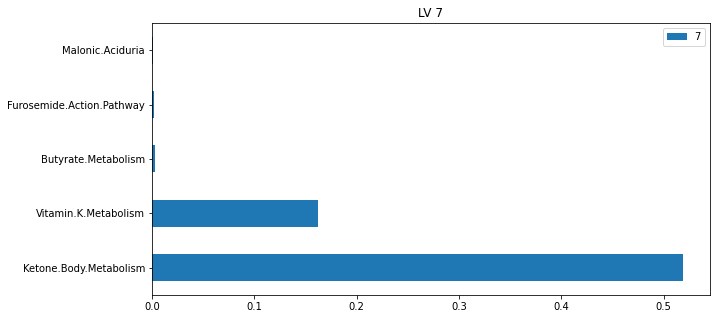

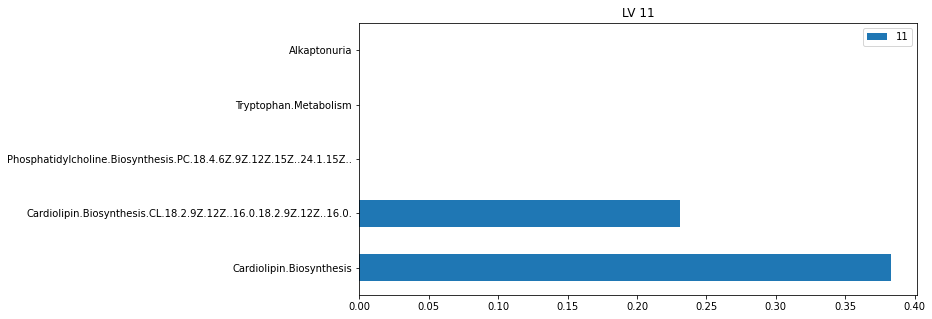

In [103]:
normomicro_model_unadj, Z_normomicro_unadj, y_normomicro_unadj = classify(model, Xtrain, Cmat, clinred_normomicro, clinadj=False)

## Top latent variables for predicting rapid eGFR decline with adjustment for clinical variables

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


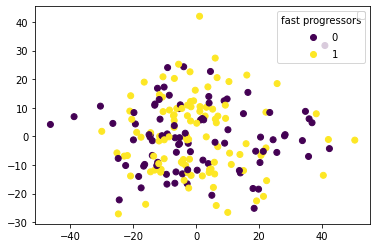

/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daniel/miniconda3/envs/autoplier/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


No LVs are associated with classification of rapid progressors!
No LVs are associated with classification of slow progressors!


In [104]:
 normomicro_model, Z_normomicro, y_normomicro = classify(model, Xtrain, Cmat, clinred_normomicro, clinadj=True)

## Comparison of ROC curves between adjusted and unadjusted models 

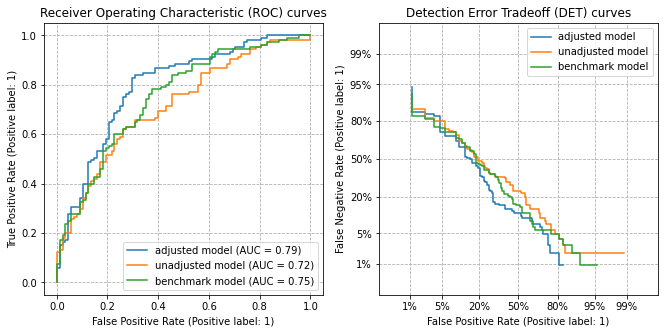

In [197]:
comapre_ROC(normomicro_model, Z_normomicro, y_normomicro,
            normomicro_model_unadj, Z_normomicro_unadj, y_normomicro_unadj,
           normomicro_model_clin, Z_normomicro_clin, y_normomicro_clin)

# Association of APRT pathway scores with composite renal outcome
We consider the composite event: Dialysis, Kidney Transplant, 50% eGFR decline, or eGFR<15 ml/min/1.73m^2. Two patient groups are split along the median APRT pathway score and the significance between the two survival curves is calculated. Finally, the prognostic strength of the binned High/Low category is quantified by C-statistic in a Cox proportional hazard model with adjustment for clinical variables. 

In [198]:
APRT_LV = '21'
pathwaydict = model.get_top_pathways([int(APRT_LV)], n_pathways=1)
df = pd.DataFrame(pathwaydict).fillna(0)

#print(df)
#print(df.index.values)

#assert we found where APRT pathway is 
assert(df.index.values[0]=='Adenine.phosphoribosyltransferase.deficiency..APRT.')

In [199]:
def setup_surv_analysis(APRT_values, clindf):

    # define events
    events = clindf['sa_allc_cric_renal3_v3y0']==1
    exit_times = clindf['sa_allc_cric_time_renal3_v3y0']

    #use only selected patients in APRT values
    events = events[events.index.isin(APRT_values.index)]
    exit_times = exit_times[exit_times.index.isin(APRT_values.index)]

    # Kaplan Meier Curve
    time, survival_prob = kaplan_meier_estimator(events, exit_times)
    plt.step(time, survival_prob, where="post")
    plt.title("Kaplan Mier curve for composite renal outcome")
    plt.ylabel("Event free probability")
    plt.xlabel("time $t$ in years")
    plt.show()
    
    return events, exit_times

In [200]:
#plot incidence rate and return stats
def analyse_incidence_rate(APRT_values, events, exit_times, quantile):

    #QC : default to 50 percentile if quanitle is not between 0 and 1.
    if quantile>=1 or quantile<=0:
        quantile=.5
    
    # partition treatment groups based on the median APRT_LV value
    #cutoff = np.median(APRT_values)
    cutoff = np.quantile(APRT_values, quantile)
    #cutoff = .60
    print("APRT cutoff value is " +str(cutoff))

    treatment_groups = pd.DataFrame()
    treatment_groups['High_APRT'] = APRT_values > cutoff
    treatment_groups['Low_APRT'] = APRT_values <= cutoff


    #select patients by record_id in the events data
    treatment_groups = treatment_groups[treatment_groups.index.isin(events.index)]
    #drop duplicate patientids
    treatment_groups = treatment_groups[~treatment_groups.index.duplicated(keep='first')]
    #get outcome for every patient in treatment_groups
    events = events.loc[treatment_groups.index]
    exit_times = exit_times.loc[treatment_groups.index]
    #confirm equal number of samples
    assert(len(events.index)==len(treatment_groups.index))
    #print(len(events.index))

    #Zip events and exit times into a list of tuples
    aux = list(zip(events, exit_times))
    # Structured array
    data_y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_years', '<f8')])

    # group indicator
    group_indicator = pd.DataFrame(index=events.index)
    group_indicator['group'] = 'High_APRT'
    group_indicator.loc[treatment_groups['Low_APRT'],'group'] = 'Low_APRT'

    # compare survival curves
    chisq, pvalue, stats, covar = compare_survival(data_y, np.array(list(group_indicator['group'])), return_stats=True)
    #print(chisq)
    #print(pvalue)
    #print(covar)

    #compare High and Low APRT groups
    for group in list(group_indicator['group'].unique()):
        mask = np.array(group_indicator==group).squeeze()
        time_treatment, survival_prob_treatment = kaplan_meier_estimator(
            events[mask],
            exit_times[mask])

        plt.step(time_treatment, 1-survival_prob_treatment, where="post",
                 label="Treatment = %s" % group)

    plt.ylabel("Incidence Rate")
    plt.xlabel("time $t$ in years")
    plt.legend(loc="best")
    plt.annotate("p_value = "+str(round(pvalue, 5)), (4,.05))
    plt.show()
    
    return stats, group_indicator

In [201]:
def setup_CPH(X, group_indicator):
    #select patients in clin data that have assigned group indication
    data_x = X[X.index.isin(group_indicator.index)] 

    #merge APRT_LV predictor and clinical covariates
    data_x = data_x.join(group_indicator)

    #drop egfr rate as predictor
    data_x.drop(columns=['mu_egfr_rate'], inplace=True)

    #encode binary sex clinical variable
    if 'sex_v3y0' in data_x.columns:
        data_x['sex_v3y0'] = data_x['sex_v3y0'].astype('category')
        #le = LabelEncoder()
        #le.fit(data_x['sex_v3y0'].unique())
        #data_x['sex_v3y0'] = le.transform(data_x['sex_v3y0'])

    #encode categorical race clinical variable
    if 'race_ethnicity_cat2_v3y0' in data_x.columns:
        data_x['race_ethnicity_cat2_v3y0'] = data_x['race_ethnicity_cat2_v3y0'].astype('category')
        #le = OneHotEncoder()#LabelEncoder()
        #le.fit(data_x['race_ethnicity_cat2_v3y0'].unique())
        #data_x['race_ethnicity_cat2_v3y0'] = le.transform(data_x['race_ethnicity_cat2_v3y0'])

    #encode binary APART_LV group variable
    data_x['group'] = data_x['group'].astype('category')
    #le = LabelEncoder()
    #le.fit(data_x['group'].unique())
    #data_x['group'] = le.transform(data_x['group'])

    #encode categorical values
    from sksurv.preprocessing import OneHotEncoder
    data_x = OneHotEncoder().fit_transform(data_x)

    #Zip events and exit times into a list of tuples
    aux = list(zip(events, exit_times))
    # Structured array
    data_y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_years', '<f8')])

    #display(data_x)
    
    return data_x, data_y

In [202]:
def cph_surv_analysis(data_x, data_y):
    from sksurv.linear_model import CoxPHSurvivalAnalysis

    #init and train proportional hazard model
    estimator = CoxPHSurvivalAnalysis()
    estimator.fit(data_x, data_y)

    #get C-statistic
    print("Concordance statistic: " + str(estimator.score(data_x, data_y)))

    # show coeffiecients, where each value corresponds to the log hazard ratio.
    lhr = pd.DataFrame(estimator.coef_, index=data_x.columns, columns=["log hazard ratio"])
    lhr = lhr.join(pd.DataFrame(np.exp(estimator.coef_), index=data_x.columns, columns=["hazard ratio"]))
    lhr =lhr.sort_values(by=['hazard ratio'], ascending=False)
    display(lhr)


## Full cohort analysis

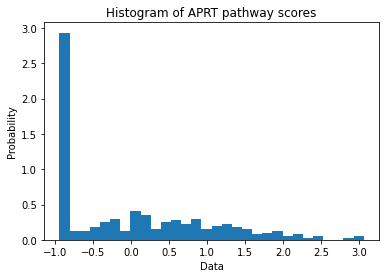

In [203]:
# partition APRT_LV value select patients by patient_id in the events data
APRT_values = Z_fullcohort.loc[Z_fullcohort.index.isin(clinred_full.index), APRT_LV]

plt.hist(APRT_values, density=True, bins=30)  # density=False would make counts
plt.title("Histogram of APRT pathway scores")
plt.ylabel('Probability')
plt.xlabel('Data');

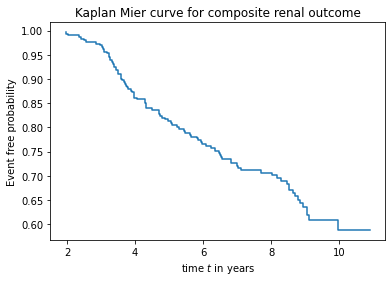

In [204]:
events, exit_times = setup_surv_analysis(APRT_values, clindf)

### Is there any difference in event probability between groups with high or low APRT pathway?

Patients are partitions at the median APRT pathway score into high_APRT and low_APRT groups and come survival curves

APRT cutoff value is -0.9482911229133606


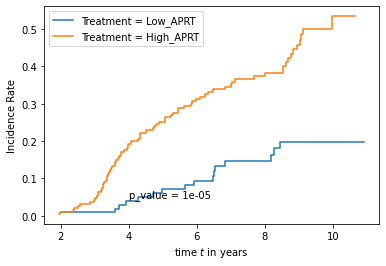

,counts,observed,expected,statistic
group,,,,
High_APRT,191,77,55.900141,21.099859
Low_APRT,107,16,37.099859,-21.099859


In [205]:
stats, group_indicator = analyse_incidence_rate(APRT_values, events, exit_times, quantile=APRT_quant)
display(stats)

### Cox Proportional Hazard

In [206]:
data_x, data_y = setup_CPH(clinred_full, group_indicator)
cph_surv_analysis(data_x, data_y)

Concordance statistic: 0.8613754989253914


,log hazard ratio,hazard ratio
race_ethnicity_cat2_v3y0=2,0.570778,1.769644e+00
log2acr,0.298844,1.348300e+00
hemoglobin_a1c_v3y0,0.253634,1.288700e+00
map_v3y0,0.026513,1.026868e+00
waist_v3y0,0.001877,1.001879e+00
age_integer_v3y0,-0.022382,9.778665e-01
egfr_cric_v3y0,-0.074537,9.281731e-01
sex_v3y0=2,-0.385734,6.799511e-01
group=Low_APRT,-0.781791,4.575858e-01
race_ethnicity_cat2_v3y0=4,-14.492598,5.080947e-07


## Normo group analysis

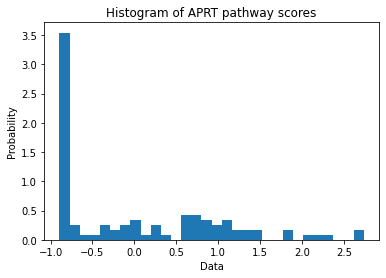

In [207]:
# partition APRT_LV value select patients by patient_id in the events data
APRT_values = Z_normo.loc[Z_normo.index.isin(clinred_normo.index), APRT_LV]

plt.hist(APRT_values, density=True, bins=30)  # density=False would make counts
plt.title("Histogram of APRT pathway scores")
plt.ylabel('Probability')
plt.xlabel('Data');

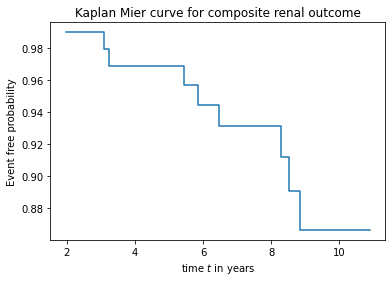

In [208]:
events, exit_times = setup_surv_analysis(APRT_values, clindf)

### Is there any difference in event probability between groups with high or low APRT pathway?

Patients are partitions at the median APRT pathway score into high_APRT and low_APRT groups and come survival curves

APRT cutoff value is -0.8940192461013794


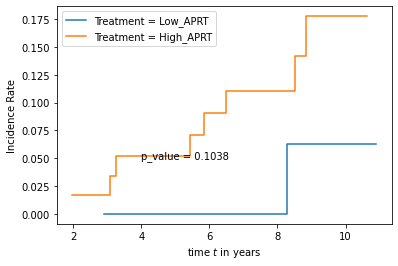

,counts,observed,expected,statistic
group,,,,
High_APRT,58,8,5.643266,2.356734
Low_APRT,40,1,3.356734,-2.356734


In [209]:
stats, group_indicator = analyse_incidence_rate(APRT_values, events, exit_times, quantile=APRT_quant)
display(stats)

### Cox Proportional Hazard

In [210]:
data_x, data_y = setup_CPH(clinred_normo, group_indicator)
cph_surv_analysis(data_x, data_y)

Concordance statistic: 0.9178515007898894


,log hazard ratio,hazard ratio
hemoglobin_a1c_v3y0,1.399658,4.053815e+00
map_v3y0,0.073505,1.076273e+00
age_integer_v3y0,0.063644,1.065712e+00
waist_v3y0,0.047713,1.048869e+00
egfr_cric_v3y0,-0.232334,7.926814e-01
log2acr,-0.834036,4.342928e-01
race_ethnicity_cat2_v3y0=2,-1.089853,3.362660e-01
sex_v3y0=2,-1.688430,1.848095e-01
group=Low_APRT,-2.680214,6.854847e-02
race_ethnicity_cat2_v3y0=4,-15.682497,1.545889e-07


## Normo+micro group analysis

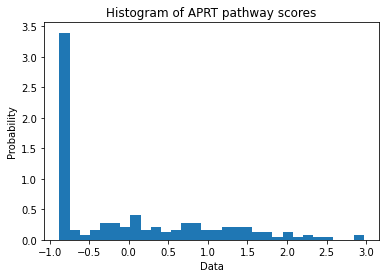

In [211]:
# partition APRT_LV value select patients by patient_id in the events data
APRT_values = Z_normomicro.loc[Z_normomicro.index.isin(clinred_normomicro.index), APRT_LV]

plt.hist(APRT_values, density=True, bins=30)  # density=False would make counts
plt.title("Histogram of APRT pathway scores")
plt.ylabel('Probability')
plt.xlabel('Data');

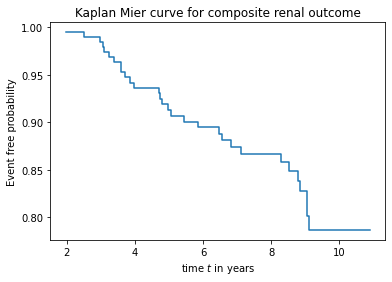

In [212]:
events, exit_times = setup_surv_analysis(APRT_values, clindf)

### Is there any difference in event probability between groups with high or low APRT pathway?

Patients are partitions at the median APRT pathway score into high_APRT and low_APRT groups and come survival curves

APRT cutoff value is -0.8760496377944946


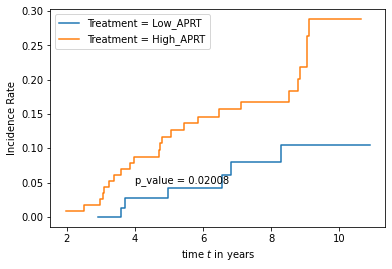

,counts,observed,expected,statistic
group,,,,
High_APRT,115,24,17.745071,6.254929
Low_APRT,78,6,12.254929,-6.254929


In [213]:
stats, group_indicator = analyse_incidence_rate(APRT_values, events, exit_times, quantile=APRT_quant)
display(stats)

### Cox Proportional Hazard

In [214]:
data_x, data_y = setup_CPH(clinred_normomicro, group_indicator)
cph_surv_analysis(data_x, data_y)

Concordance statistic: 0.870426474015381


,log hazard ratio,hazard ratio
hemoglobin_a1c_v3y0,0.727909,2.070746e+00
sex_v3y0=2,0.645626,1.907181e+00
log2acr,0.117556,1.124744e+00
age_integer_v3y0,0.079374,1.082609e+00
map_v3y0,0.030089,1.030546e+00
waist_v3y0,0.007595,1.007624e+00
egfr_cric_v3y0,-0.121025,8.860122e-01
race_ethnicity_cat2_v3y0=2,-0.382402,6.822206e-01
group=Low_APRT,-0.746379,4.740799e-01
race_ethnicity_cat2_v3y0=3,-12.580324,3.439021e-06
